# XGBoost MODEL BUILD

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Train and Test Datasets

In [5]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


# Set dataset directory path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/"

# Load preprocessed train and test sets
train_df = pd.read_csv(dataset_path + "train.csv")
test_df = pd.read_csv(dataset_path + "test.csv")

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

Train dataset shape: (1515164, 16)
Test dataset shape: (726426, 16)


# Separate Features and Labels

In [6]:
print("Train Columns:", train_df.columns.tolist())
print("Test Columns:", test_df.columns.tolist())

Train Columns: ['Total Length of Bwd Packets', 'Packet Length Std', 'Subflow Bwd Bytes', 'Fwd Packet Length Max', 'Bwd Packet Length Max', 'Total Length of Fwd Packets', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Variance', 'Init_Win_bytes_backward', 'Init_Win_bytes_forward', 'Avg Bwd Segment Size', 'Subflow Fwd Bytes', 'Bwd Packet Length Mean', 'Average Packet Size', 'Label']
Test Columns: ['Total Length of Bwd Packets', 'Packet Length Std', 'Subflow Bwd Bytes', 'Fwd Packet Length Max', 'Bwd Packet Length Max', 'Total Length of Fwd Packets', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Variance', 'Init_Win_bytes_backward', 'Init_Win_bytes_forward', 'Avg Bwd Segment Size', 'Subflow Fwd Bytes', 'Bwd Packet Length Mean', 'Average Packet Size', 'Label']


In [7]:
# Identify feature columns (all except label columns)
label_column = 'Label'
feature_columns = [col for col in train_df.columns if col != label_column]

# Extract features (X) and labels (y)
X_train, y_train = train_df[feature_columns], train_df[label_column]
X_test, y_test = test_df[feature_columns], test_df[label_column]

# Encode labels into integer categories
y_train, label_encoder = pd.factorize(y_train)
y_test = label_encoder.get_indexer(y_test)

print(f"Feature columns: {len(feature_columns)}, Label classes: {len(label_encoder)}")
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Feature columns: 15, Label classes: 13
Training samples: 1515164, Testing samples: 726426


# Define and Train the XGBoost Model

In [19]:
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
num_classes = len(np.unique(y_train))

model = XGBClassifier(
    n_estimators=1500,
    max_depth=5,
    learning_rate=0.5,
    objective='binary:logistic'
)

start = time.time()
model.fit(X_train, y_train)
end = time.time()

print(f'Elapsed Training Time: {(end - start)/60:.2f} minutes')
print("Number of Features Used:", X_train.shape[1])

Elapsed Training Time: 48.68 minutes
Number of Features Used: 15


# Perform Predictions

In [ ]:
import time
start = time.time()
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
end = time.time()

print(f'Elapsed Prediction Time: {(end - start)/60:.2f} minutes')

# Generate Confusion Matrix

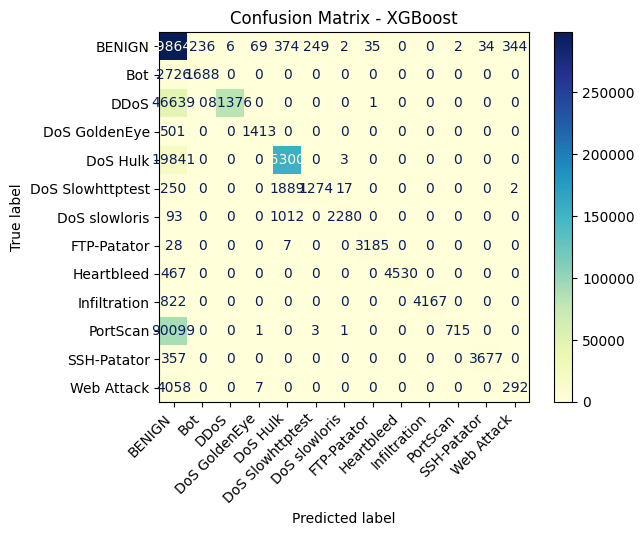


Classification Report:
                  precision    recall  f1-score   support

          BENIGN       0.64      1.00      0.78    300000
             Bot       0.88      0.38      0.53      4414
            DDoS       1.00      0.64      0.78    128016
   DoS GoldenEye       0.95      0.74      0.83      1914
        DoS Hulk       0.98      0.89      0.93    172849
DoS Slowhttptest       0.83      0.37      0.51      3432
   DoS slowloris       0.99      0.67      0.80      3385
     FTP-Patator       0.99      0.99      0.99      3220
      Heartbleed       1.00      0.91      0.95      4997
    Infiltration       1.00      0.84      0.91      4989
        PortScan       1.00      0.01      0.02     90819
     SSH-Patator       0.99      0.91      0.95      4034
      Web Attack       0.46      0.07      0.12      4357

        accuracy                           0.77    726426
       macro avg       0.90      0.65      0.70    726426
    weighted avg       0.84      0.77      0.7

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate Classification Report
# ✅ Load the saved LabelEncoder
encoder_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/label_encoder.pkl"
label_encoder = joblib.load(encoder_path)

# ✅ Convert class labels to strings
class_names = [str(cls) for cls in label_encoder.classes_]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='YlGnBu', values_format='d')

plt.title("Confusion Matrix - XGBoost")
plt.xticks(rotation=45, ha="right")
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Compute Performance Metrics

In [22]:
def ACC(TP, TN, FP, FN):
    return (TP + TN) / (TP + FP + FN + TN)

def PRECISION(TP, FP):
    return TP / (TP + FP)

def RECALL(TP, FN):
    return TP / (TP + FN)

def F1(Recall, Precision):
    return 2 * Recall * Precision / (Recall + Precision)

def BACC(TP, TN, FP, FN):
    return (TP / (TP + FN) + TN / (TN + FP)) * 0.5

def MCC(TP, TN, FP, FN):
    TP, TN, FP, FN = map(np.float64, [TP, TN, FP, FN])
    numerator = (TN * TP - FN * FP)
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return numerator / denominator if denominator else 0

# Extract True Positives, False Positives, False Negatives, and True Negatives
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Compute Metrics
Acc = ACC(sum(TP), sum(TN), sum(FP), sum(FN))
Precision = PRECISION(sum(TP), sum(FP))
Recall = RECALL(sum(TP), sum(FN))
F1_score = F1(Recall, Precision)
BACC_score = BACC(sum(TP), sum(TN), sum(FP), sum(FN))
MCC_score = MCC(sum(TP), sum(TN), sum(FP), sum(FN))

# Print Performance Metrics
print(f'Accuracy: {Acc:.4f}')
print(f'Precision: {Precision:.4f}')
print(f'Recall: {Recall:.4f}')
print(f'F1 Score: {F1_score:.4f}')
print(f'BACC: {BACC_score:.4f}')
print(f'MCC: {MCC_score:.4f}')



Accuracy: 0.9640
Precision: 0.7657
Recall: 0.7657
F1 Score: 0.7657
BACC: 0.8731
MCC: 0.7462


# Compute AUC-ROC Score

In [23]:
# Compute AUC-ROC Score
n_classes = len(label_encoder.classes_)
auc_score = roc_auc_score(label_binarize(y_test, classes=range(n_classes)), y_pred_proba, multi_class="ovr")
print(f"AUC-ROC Score: {auc_score:.4f}")

AUC-ROC Score: 0.9675


# Save the Trained XGBoost Model

In [24]:
# Save the trained model
model_folder = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/"
model_filename = "CICIDS-2017_XGBoost.joblib"
model_path = model_folder + model_filename
joblib.dump(model, model_path)

print(f"🚀 **XGBoost model saved to:** {model_path}")


🚀 **XGBoost model saved to:** /content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/CICIDS-2017_XGBoost.joblib
